# Laboratorium 4

### Konfiguracja

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [58]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


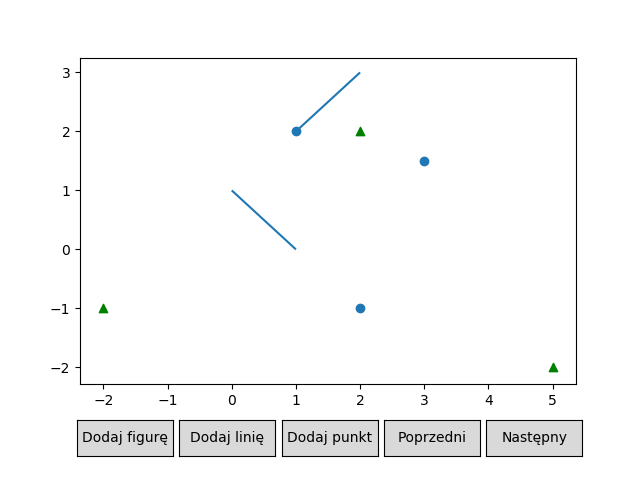

In [59]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

In [60]:
# scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
#               [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
#         Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
#                PointsCollection([(5, -2)], color='black')])]
# plot = Plot(scenes)

# with open('somefile.json', 'w') as file:
#     file.write(plot.toJson())
    
# #somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
# with open('somefile.json', 'r') as file:
#     json = file.read()
    
# plot2 = Plot(json=json)
# plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


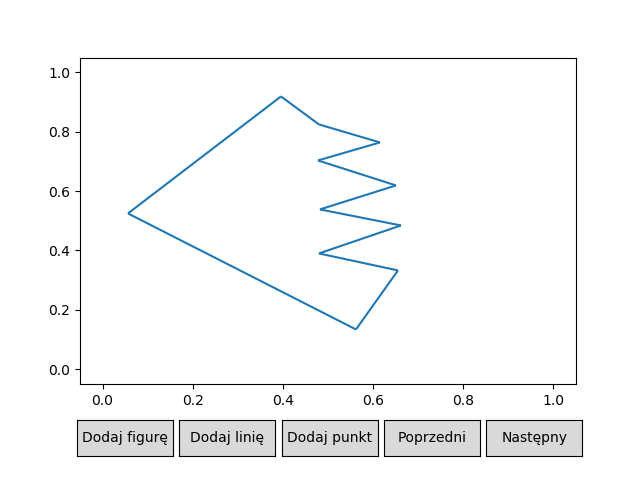

In [61]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

In [62]:
added_elements = plot1.get_added_figure()
lines = []
for line in added_elements[0].lines:
    lines.append(line)
    
points = []
point_max = lines[0][0]
max_index = 0
for i in range(len(lines)):
    if lines[i][0][1] > point_max[1]:
        point_max = line[0]
        max_index = i
        
for i in range(max_index, len(lines)):
    points.append(lines[i][0])
    
for i in range(0, max_index):
    points.append(lines[i][0])

for point in points:
    print(point)

(0.39569682459677424, 0.9191138174019609)
(0.05638230846774195, 0.5248123468137256)
(0.5620274697580645, 0.13388097426470585)
(0.6551726310483871, 0.33271675857843136)
(0.4799710181451613, 0.390008425245098)
(0.6618258568548387, 0.4843711703431372)
(0.48218876008064515, 0.5382927389705883)
(0.6507371471774194, 0.6191750919117647)
(0.47775327620967745, 0.7034275428921568)
(0.6152532762096774, 0.7640893075980393)
(0.4799710181451613, 0.8247510723039215)


In [13]:
# plot2 = Plot([plot1.get_added_elements()])
# plot2.draw()

# added_elements = plot1.get_added_figure()
# lines = []
# for line in added_elements[0].lines:
#     lines.append(line)
# print(lines)
# Plot([Scene(lines=[LinesCollection(lines)])]).draw()

### Rozwiązanie

In [76]:
%matplotlib notebook
from enum import Enum

# poligon_yes = [(10, 10), (8, 8), (7, 6), (8, 4), (11, 2), (9, -2), (12, -4), (15, 2), (14, 6)]

# poligon_no = [(2,8), (0,6), (-1,7), (-3, 4), (-2, 1), (0, 0), (3, 2), (4, 5)]

poligon_yes = [(11,15),(3,10),(13,0),(17,2),(13,5),(16,6),(13,8),(17,9),(14,10),(17,11),(14,12)]

In [169]:
epsilon = 1e-5

class Orientation(Enum):
    left = 'left'
    colinear = 'colinear'
    right = 'right'

def determinant(a, b, c):
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - b[1]*c[0] - a[1]*b[0] - a[0]*c[1]

def orient(a, b, c):
    det = determinant(a, b, c)
    if abs(det) < epsilon:
        return Orientation.colinear
    elif det > 0:
        return Orientation.left
    elif det < 0:
        return Orientation.right

In [170]:
class PointType(Enum):
    start = 'start'
    end = 'end'
    connect = 'connect'
    divide = 'divide'
    proper = 'proper'

In [171]:
def point_type(former, current, latter):
    orientation = orient(former, current, latter)
    higher_than_former = current[1] > former[1]
    higher_then_latter = current[1] > latter[1]

    if higher_than_former and higher_then_latter:
        return PointType.start if orientation == Orientation.left else PointType.divide
    if not (higher_than_former or higher_then_latter):
        return PointType.end if orientation == Orientation.left else PointType.connect
    return PointType.proper

#### Y monotoniczność

In [172]:
def y_mon(points):
    if len(points) < 3:
        return

    points_and_types = []
    
    p_type = point_type(points[len(points)-1], points[0], points[1])
    points_and_types.append((points[0], p_type))
    for i in range(2, len(points)):
        p_type = point_type(points[i-2], points[i-1], points[i])
        points_and_types.append((points[i-1], p_type))
    
    for point in points_and_types:
        if point[1] == PointType.connect or point[1] == PointType.divide:
            return False, points_and_types
    
    return True, points_and_types

### Kolorowanie wierzchołków wizualizacja

<IPython.core.display.Javascript object>


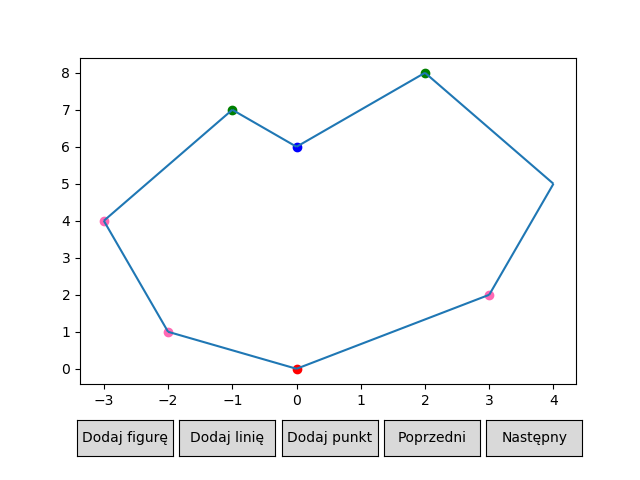

In [173]:
def points_to_lines(points):
    lines = []
    for i in range(1, len(points)):
        lines.append([points[i], points[i-1]])
    lines.append([points[len(points)-1], points[0]]) 
    return lines

def visualize_point_types(points):
    mon_y, points_and_types = y_mon(points)
    
    start_points = []
    end_points = []
    connect_points = []
    divide_points = []
    proper_points = []
    
    for point in points_and_types:
        if point[1] == PointType.start:
            start_points.append(point[0])
        elif point[1] == PointType.end:
            end_points.append(point[0])
        elif point[1] == PointType.connect:
            connect_points.append(point[0])
        elif point[1] == PointType.divide:
            divide_points.append(point[0])
        elif point[1] == PointType.proper:
            proper_points.append(point[0])
            
    poligon_lines = points_to_lines(points)
    
    scene=[Scene([PointsCollection(start_points, color='green'),
                  PointsCollection(end_points, color='red'),
                  PointsCollection(connect_points, color='blue'),
                  PointsCollection(divide_points, color='cyan'),
                  PointsCollection(proper_points, color='hotpink')],
                 [LinesCollection(poligon_lines)])]
    Plot(scene).draw()
    
visualize_point_types(poligon_no)

## Triangulacja

In [174]:
def find_max(points):
    max_point = points[0]
    max_index = 0
    
    for i in range(1, len(points)):
        if max_point[1] < points[i][1]:
            max_point = points[i]
            max_index = i
            
    return max_point, max_index

def find_min(points):
    min_point = points[0]
    min_index = 0
    
    for i in range(1, len(points)):
        if min_point[1] > points[i][1]:
            min_point = points[i]
            min_index = i
            
    return min_point, min_index

def chains(points, max_index, min_index):
    left_chain = set()
    right_chain = set()
    
    start = max_index
    stop = min_index
    
    while start != stop:
        left_chain.add(points[start])
        start = (start + 1) % len(points)
        
    start = max_index
    while start != stop:
        right_chain.add(points[start])
        start = start - 1 if start > 0 else len(points) - 1
        
    left_chain.add(points[min_index])
    right_chain.add(points[min_index])
        
    return left_chain, right_chain

In [181]:
def Triangulate(points):
    if not y_mon(points)[0]:
        print('Nie jest y monotoniczny')
        return
    
    steps = []
    
    max_point, max_index = find_max(points)
    min_point, min_index = find_min(points)
    
    left_chain, right_chain = chains(points, max_index, min_index)
    
    sorted_points = points.copy()
    sorted_points.sort(key=lambda x: (x[1], -x[0]), reverse=True)
    
    triangulation_edges = set()
    for i in range(1, len(points)):
        triangulation_edges.add((points[i], points[i-1]))
    triangulation_edges.add((points[len(points)-1], points[0]))
    
    stack = []
    stack.append(sorted_points[0])
    stack.append(sorted_points[1])
    
    for i in range(2, len(points)):
        steps.append(triangulation_edges.copy())
        
        top = stack.pop()
        if (top in left_chain and sorted_points[i] in right_chain) or \
           (top in right_chain and sorted_points[i] in left_chain):
            
            triangulation_edges.add((sorted_points[i], top))
            while len(stack) > 1:
                p = stack.pop()
                triangulation_edges.add((sorted_points[i], p))
            stack.pop()
            
            stack.append(top)
            stack.append(sorted_points[i])
            
        else:
            
            if top in left_chain:
                orientation = Orientation.left
            else:
                orientation = Orientation.right
                
            while len(stack) > 0:
                if orient(top, sorted_points[i], stack[len(stack)-1]) == orientation:
                    top = stack.pop()
                    triangulation_edges.add((sorted_points[i], top))
                else:
                    break
            
            stack.append(top)
            stack.append(sorted_points[i])
                    
    return triangulation_edges, steps

In [182]:
def visualize_triangulation_edges(triangulation_edges, steps):
    tiring_lines = []
    for edge in triangulation_edges:
        tiring_lines.append([edge[0], edge[1]])
    scenes = []
    scenes.append(tiring_lines)
    
    for step in steps:
        tiring_lines = []
        for edge in step:
            tiring_lines.append([edge[0], edge[1]])
        scenes.append(tiring_lines)
    return scenes
            

triangulation_edges, steps = Triangulate(poligon_yes)
ehh = visualize_triangulation_edges(triangulation_edges, steps)

<IPython.core.display.Javascript object>


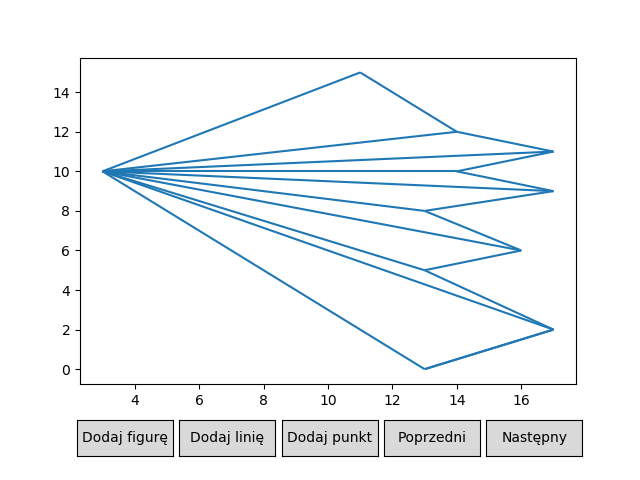

In [183]:
scenes = []
for eh in ehh:
    scenes.append(Scene(lines=[LinesCollection(eh)]))
plot = Plot(scenes)
plot.draw()